# Hybrid flow shop

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/PyJobShop/PyJobShop/blob/main/examples/hybrid_flow_shop.ipynb)

> If you're using this notebook in Google Colab, be sure to install PyJobShop first by executing ```pip install pyjobshop``` in a cell.

In this notebook, we demonstrate how to model and solve a hybrid flow shop (HFS) problem using PyJobShop.

The HFS is a common manufacturing environment in practice and widely studied by scheduling researchers. See for example the surveys by [Ruiz and Vázquez-Rodríguez (2010)](https://www.sciencedirect.com/science/article/pii/S0377221709006390) and [Ribas et al. (2010)](https://www.sciencedirect.com/science/article/pii/S0305054809002883) for an overview of HFS studies.

## Problem description
The HFS problem is characterized as follows:

- There is a set of $n$ jobs that need to be processed in a series of stages.
- The number of processing stages is at least 2.
- Each stage has at least one machine in parallel, and in at least one stage there is more than one machine.
- All jobs are processed in the same production order: production starts in stage 1, then stage 2, etc. until the last stage. A job can only start processing when it has finished processing in the previous stage.

The figure below illustrates a small HFS manufacturing environment. The first stage has three machines, the second stage has two machines, and the third stage only has one machine. Each machine name $M_{kl}$ describes the stage $k$ and $l$-th machine in the stage. The machines in each stage are identical, meaning that each machine has the same processing speed for a given job.

```
Stage 0        Stage 1        Stage 2
┌─────┐        ┌─────┐        ┌─────┐
│ M00 │───┬───▶│ M10 │───┬───▶│ M20 │
└─────┘   │    └─────┘   │    └─────┘
          │              │
┌─────┐   │    ┌─────┐   │
│ M01 │───┼───▶│ M11 │───┘
└─────┘   │    └─────┘
          │
┌─────┐   │
│ M02 │───┘
└─────┘
```

We can model an HFS problem using PyJobShop. Define a task $T_{jk}$ for each job $j$ and each stage $k$. Each task represents the processing of the given job at the given stage. We also need to make sure that the previous task $T_{j, k-1}$ is processed before $T_{jk}$ for $k > 1$.

Let's now implement the above example using PyJobShop's Model interface.

## Model

In [51]:
num_jobs = 10
num_stages = 3
num_machines = [3, 2, 1]

Let's add some randomly generated processing times. The processing times of tasks depend only on the corresponding job and stage of the task.

In [52]:
import random

random.seed(42)

PROCESSING_TIMES = {
    (job, stage): random.randint(5, 20)
    for job in range(num_jobs)
    for stage in range(num_stages)
}

Now that all our parameters are defined, we can start defining the model.

In [53]:
from pyjobshop import Model

model = Model()

First define the machine layout:

In [54]:
def machine_name(machine, stage):
    return f"$M_{{{stage}{machine}}}$"

stage2machines = {}
for k in range(num_stages):
    stage2machines[k] = [
        model.add_machine(name=machine_name(m, k))
        for m in range(num_machines[k])
    ]

Now, we need to define jobs and the tasks that have to be scheduled.

In [55]:
jobs = [model.add_job() for _ in range(num_jobs)]

def task_name(job: int, stage: int):
    return f"$T_{{{job}{stage}}}$"

tasks = {}
for j, job in enumerate(jobs):
    for k in range(num_stages):
        tasks[j, k] = model.add_task(job=job, name=task_name(j, k))

Next, we have to add processing times for each task through defining the corresponding modes. Remember that each task can be processed on every machine in its given stage, so we have to define a mode for every machine.

In [56]:
for j, job in enumerate(jobs):
    for k in range(num_stages):
        for machine in stage2machines[k]:
            duration = PROCESSING_TIMES[j, k]
            task = tasks[j, k]
            model.add_mode(task, machine, duration)

The final restriction is to make sure that the previous task $T_{j, k-1}$ is processed before $T_{jk}$ for $k > 1$, which can be achieved by adding precedence constraints.

In [57]:
for j, job in enumerate(jobs):
    for k in range(num_stages - 1):
        first = tasks[j, k]
        second = tasks[j, k+1]
        model.add_end_before_start(first, second)

That's it! We've completed the modeling of an HFS instance. Let's now solve it and plot the Gantt chart.

In [58]:
result = model.solve(display=False)
print(result)

Solution results
  objective: 113.00
lower bound: 113.00
     status: Optimal
    runtime: 0.01 seconds


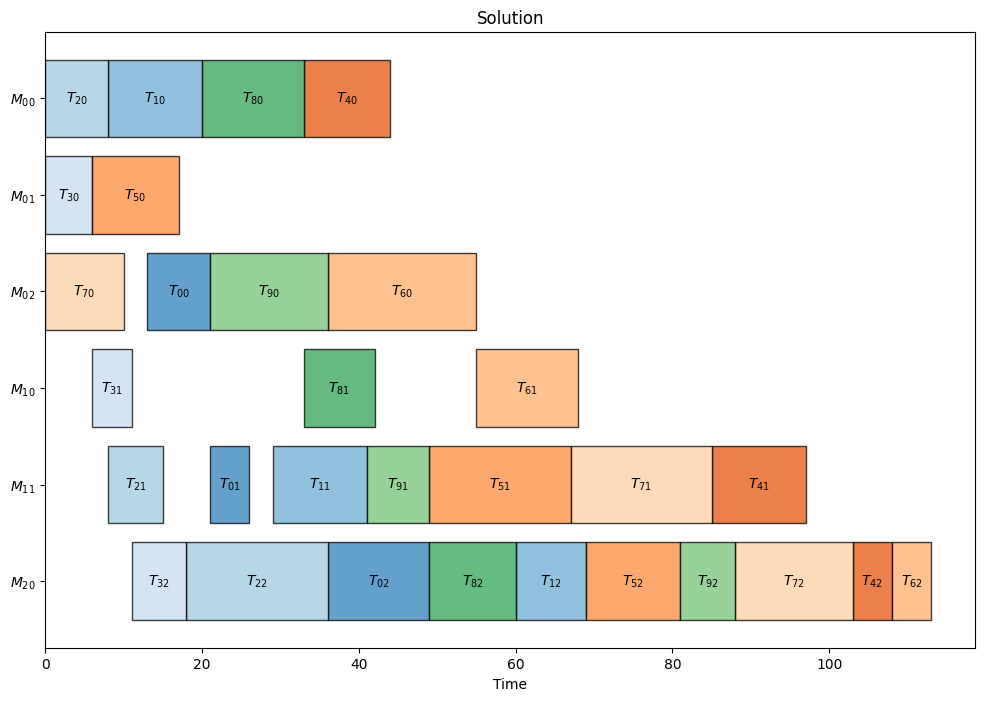

In [59]:
from pyjobshop.plot import plot_machine_gantt

data = model.data()
plot_machine_gantt(result.best, model.data(), plot_labels=True)

Note the following things.
- Each "Job" moves through.
- Task precdence is respected
TODO

In the next sections, we will demonstrate several variations of the HFS problem, showing how you can modify and tailor your scheduling problems using PyJobShop's features.

## No-wait

What if a job $j$ is not allowed to wait, meaning that $T_{jk}$ must start processing exactly when $T_{j,k-1}$ is finished? This is known in the literature as the _no-wait_ constraint: this is, for example, required when jobs need continuous processing to ensure they stay at a certain temperature. The way to implement this constraint with PyJobShop is to use `model.add_end_at_start` instead of `model.add_end_before_start` as a precedence constraint. Below we define the same model, but with the precedence constraint replaced.

In [60]:
model = Model()

stage2machines = {}
for k in range(num_stages):
    stage2machines[k] = [
        model.add_machine(name=machine_name(m, k))
        for m in range(num_machines[k])
    ]

jobs = [model.add_job() for _ in range(num_jobs)]

for j, job in enumerate(jobs):
    tasks = [
        model.add_task(job=job, name=task_name(j, k)) for k in range(num_stages)
    ]

    for stage in range(num_stages):
        for machine in stage2machines[stage]:
            duration = PROCESSING_TIMES[j, stage]
            model.add_mode(tasks[stage], machine, duration)

    for idx in range(num_stages - 1):
        first = tasks[idx]
        second = tasks[idx + 1]
        # This is the same as end(first) == start(second).
        model.add_end_before_start(first, second)
        model.add_start_before_end(second, first)

In [61]:
result = model.solve(display=False)
print(result)

Solution results
  objective: 113.00
lower bound: 113.00
     status: Optimal
    runtime: 0.01 seconds


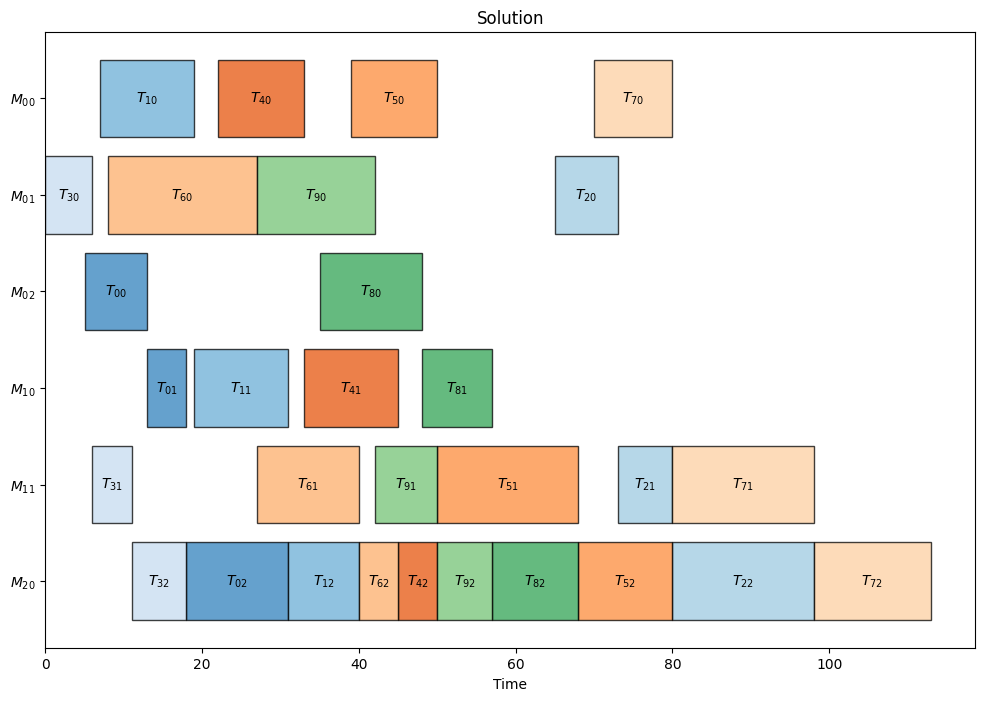

In [62]:
plot_machine_gantt(result.best, model.data(), plot_labels=True)

Compared to the first plot, this solution has much more gaps: the tasks are intentionally delayed to avoid any waiting times. This fortunately has no impact on the final makespan.

## Blocking

Another common constraint in HFS environments is blocking of tasks. In this case, $T_{jk}$ does not need to start right away when $T_{j,k-1}$ is finished, but it will continue to occupy the machine. We can do that by keeping the same constraints as the no-wait setting, but we relax the assumption that tasks have a fixed duration. By default, all tasks have a fixed duration (determined by their processing mode), but in blocking flow shops we can have tasks with variable durations as they depend on whether the machine is blocking or not.  We can do this by setting the `fixed_duration` to `False` for the task. 

In [63]:
model = Model()

stage2machines = {}
for k in range(num_stages):
    stage2machines[k] = [
        model.add_machine(name=machine_name(m, k))
        for m in range(num_machines[k])
    ]

jobs = [model.add_job() for _ in range(num_jobs)]

for j, job in enumerate(jobs):
    tasks = [
        model.add_task(job=job, fixed_duration=False, name=task_name(j, k))
        for k in range(num_stages)
    ]

    for stage in range(num_stages):
        for machine in stage2machines[stage]:
            duration = PROCESSING_TIMES[j, stage]
            model.add_mode(tasks[stage], machine, duration)

    for idx in range(num_stages - 1):
        first = tasks[idx]
        second = tasks[idx + 1]
        # This is the same as end(first) == start(second).
        model.add_end_before_start(first, second)
        model.add_start_before_end(second, first)

In [64]:
result = model.solve(display=False)
print(result)

Solution results
  objective: 113.00
lower bound: 113.00
     status: Optimal
    runtime: 0.02 seconds


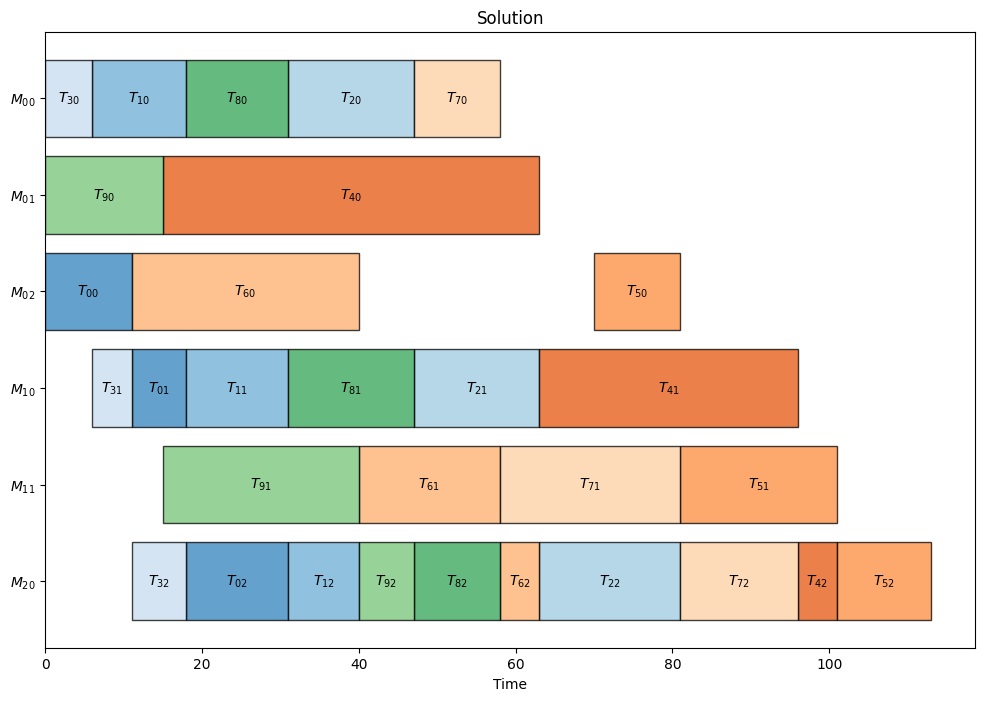

In [65]:
plot_machine_gantt(result.best, model.data(), plot_labels=True)

This plot shows that the tasks take indeed much longer than their processing times: $T_{11}$ takes now longer than 40 time units, but if you look at the first plot, it should only take around 10 time units. 

## Transportation restrictions

```
Stage 1        Stage 2        Stage 3
┌─────┐        ┌─────┐        ┌─────┐
│ M1  │───┬───▶│ M4  │───┬───▶│ M6  │
└─────┘   │    └─────┘   │    └─────┘
          │              │
┌─────┐   │    ┌─────┐   │
│ M2  │───┼───▶│ M5  │───┘
└─────┘   │    └─────┘
          │
┌─────┐   │
│ M3  │───┘
└─────┘
```

In some manufacturing environments, there may be physical restrictions between machines that allow tasks only to be scheduled between machines that are connected to each other. For example, consider this example:

```
Stage 0        Stage 1        Stage 2
┌─────┐        ┌─────┐        ┌─────┐
│ M00 │───────▶│ M10 │───┬───▶│ M20 │
└─────┘        └─────┘   │    └─────┘
                         │
┌─────┐        ┌─────┐   │
│ M01 │───┬───▶│ M11 │───┘
└─────┘   │    └─────┘
          │
┌─────┐   │
│ M02 │───┘
└─────┘
```
The HFS in this case only allows products that are scheduled on $M_{01}$, to be consecutively processed on $M_{10}$ and not $M_{11}$. 

This is an advanced example where we can use the `ModeDependency` constraint.
Effectively, what we did is that we modeled each job as tasks.
Each task has modes, meaning that it can be scheduled on a given machine.
The mode dependency constraint can be used to restrict which modes can be selected.

In [66]:
model = Model()

stage2machines = {}
for k in range(num_stages):
    stage2machines[k] = [
        model.add_machine(name=machine_name(m, k))
        for m in range(num_machines[k])
    ]

jobs = [model.add_job() for _ in range(num_jobs)]

for j, job in enumerate(jobs):
    tasks = [
        model.add_task(job=job, name=task_name(j, k)) for k in range(num_stages)
    ]
    modes = {}

    for stage in range(num_stages):
        for machine in stage2machines[stage]:
            duration = PROCESSING_TIMES[j, stage]
            mode = model.add_mode(tasks[stage], machine, duration)
            modes[stage, machine] = mode

    for idx in range(num_stages - 1):
        first = tasks[idx]
        second = tasks[idx + 1]
        model.add_end_before_start(first, second)

    # Add mode dependency constraints.
    allowed = {0: [0], 1: [0, 1], 2: [1]}
    for machine_idx, machine in enumerate(stage2machines[0]):
        mode = modes[0, machine]
        modes_to = [
            modes[1, stage2machines[1][next_machine]]
            for next_machine in allowed[machine_idx]
        ]
        model.add_mode_dependency(mode, modes_to)

In [67]:
result = model.solve(display=False)
print(result)

Solution results
  objective: 113.00
lower bound: 113.00
     status: Optimal
    runtime: 0.01 seconds


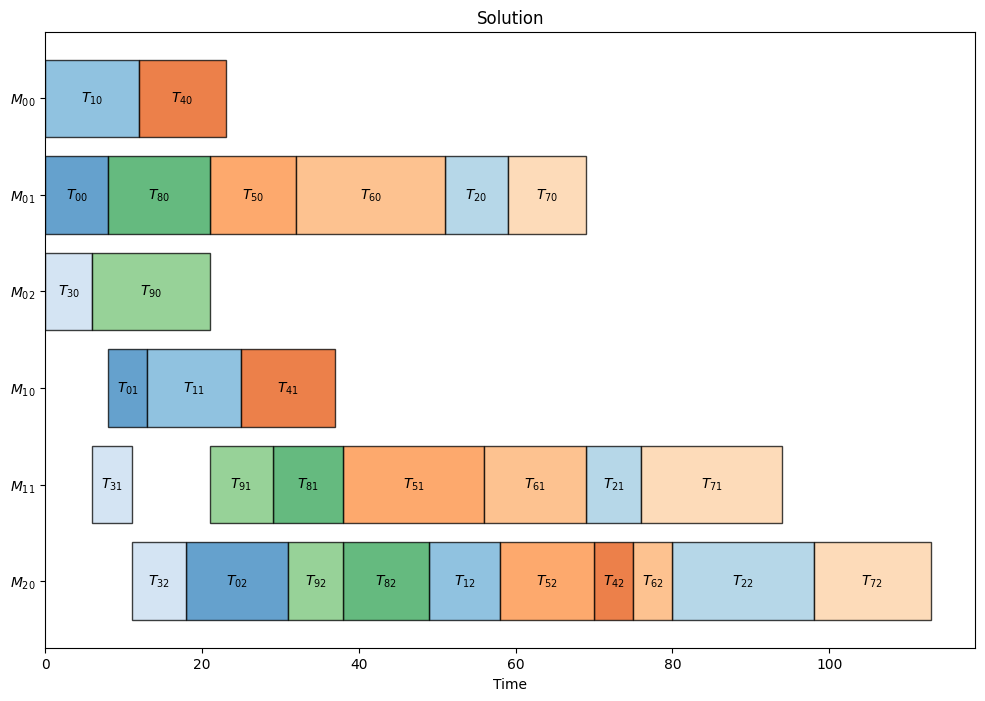

In [68]:
plot_machine_gantt(result.best, model.data(), plot_labels=True)

Here you see that any task that was scheduled on machine $M_{00}$ must also be scheduled on machine $M_{10}$, and if scheduled on machine $M_{02}$ it must be scheduled on $M_{10}$.

## Conclusion
This notebooks showed how to model and solve the hybrid flow shop problem using PyJobShop. Specifically, we show how to define the hybrid flow shop problem in terms of tasks and how to add precedence constraints between tasks, which result in no-wait and blocking variants of the problem.